# TP noté 2 – Évaluation des classificateurs binaires et régression logistique

Ce notebook contient l'implémentation des métriques, l'entraînement des modèles de régression logistique et l'analyse des seuils de décision.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import os

%matplotlib inline
np.set_printoptions(precision=4, suppress=True)

## 0) Chargement des données

In [2]:
# Les fichiers sont supposés être dans le même dossier que le notebook
x_train = pd.read_csv("x_train.csv")
y_train = pd.read_csv("y_train.csv")
x_valid = pd.read_csv("x_valid.csv")
y_valid = pd.read_csv("y_valid.csv")
x_test = pd.read_csv("x_test.csv")
y_test = pd.read_csv("y_test.csv")

def _to_1d(y_df):
    if isinstance(y_df, pd.DataFrame):
        return y_df.iloc[:, 0].astype(int).values
    return np.asarray(y_df).astype(int).reshape(-1)

ytr = _to_1d(y_train)
yva = _to_1d(y_valid)
yte = _to_1d(y_test)

print(f"Données chargées : Train {x_train.shape}, Valid {x_valid.shape}, Test {x_test.shape}")

Données chargées : Train (390, 3), Valid (180, 3), Test (180, 3)


## Bloc A — Métriques pour prédictions binaires (NumPy)

In [3]:
def calc_TP_TN_FP_FN(y_true, y_pred):
    '''
    Calcule les Vrais Positifs, Vrais Négatifs, Faux Positifs et Faux Négatifs.
    '''
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return int(TP), int(TN), int(FP), int(FN)

def calc_ACC(y_true, y_pred):
    '''Calcule l'Accuracy.'''
    TP, TN, FP, FN = calc_TP_TN_FP_FN(y_true, y_pred)
    total = TP + TN + FP + FN
    return (TP + TN) / total if total > 0 else np.nan

def calc_TPR(y_true, y_pred):
    '''Calcule le TPR (Sensibilité / Rappel).'''
    TP, TN, FP, FN = calc_TP_TN_FP_FN(y_true, y_pred)
    denom = TP + FN
    return TP / denom if denom > 0 else np.nan

def calc_TNR(y_true, y_pred):
    '''Calcule le TNR (Spécificité).'''
    TP, TN, FP, FN = calc_TP_TN_FP_FN(y_true, y_pred)
    denom = TN + FP
    return TN / denom if denom > 0 else np.nan

def calc_PPV(y_true, y_pred):
    '''Calcule la PPV (Valeur Prédictive Positive / Précision).'''
    TP, TN, FP, FN = calc_TP_TN_FP_FN(y_true, y_pred)
    denom = TP + FP
    return TP / denom if denom > 0 else np.nan

def calc_NPV(y_true, y_pred):
    '''Calcule la NPV (Valeur Prédictive Négative).'''
    TP, TN, FP, FN = calc_TP_TN_FP_FN(y_true, y_pred)
    denom = TN + FN
    return TN / denom if denom > 0 else np.nan

# Tests Unitaires pour vérifier l'implémentation
yt_test = np.array([1, 1, 0, 0, 1, 0])
yp_test = np.array([1, 0, 0, 0, 1, 1])
TP, TN, FP, FN = calc_TP_TN_FP_FN(yt_test, yp_test)
print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
assert (TP, TN, FP, FN) == (2, 2, 1, 1)
assert abs(calc_ACC(yt_test, yp_test) - (4/6)) < 1e-12
print("Tests A1 : OK")

TP=2, TN=2, FP=1, FN=1
Tests A1 : OK


## A2) Analyse descriptive des données

In [4]:
def summarize_split(y):
    return {
        "total_obs": int(len(y)),
        "cas_positifs": int(y.sum()),
        "fraction_positifs": float(y.mean())
    }

summary = pd.DataFrame({
    "Train": summarize_split(ytr),
    "Valid": summarize_split(yva),
    "Test":  summarize_split(yte),
}).T
display(summary)

,total_obs,cas_positifs,fraction_positifs
Train,390.0,55.0,0.141026
Valid,180.0,25.0,0.138889
Test,180.0,25.0,0.138889


## Bloc B — Baseline 'predict-0-always'

In [5]:
# Classificateur naïf qui prédit toujours 0 (pas de cancer)
y_pred0_test = np.zeros_like(yte)
TP, TN, FP, FN = calc_TP_TN_FP_FN(yte, y_pred0_test)
cm0 = np.array([[TN, FP], [FN, TP]])
acc0 = calc_ACC(yte, y_pred0_test)
print(f"Matrice de Confusion Baseline (Orientation: [[TN, FP], [FN, TP]]) :\n{cm0}")
print(f"Accuracy Baseline : {acc0:.4f}")

Matrice de Confusion Baseline (Orientation: [[TN, FP], [FN, TP]]) :
[[155   0]
 [ 25   0]]
Accuracy Baseline : 0.8611


## Bloc C — Régression logistique et sélection de modèles

In [6]:
# Définition des jeux de variables
cols_F2 = ["age", "famhistory"]
cols_F3 = ["marker", "age", "famhistory"]

# Grille de valeurs pour le paramètre de régularisation C
C_grid = np.logspace(-9, 6, 31)

def fit_lr_best_C(Xtr, ytr, Xva, yva, C_grid):
    '''
    Entraîne des modèles de régression logistique pour chaque C et sélectionne 
    celui qui minimise la log-loss sur le jeu de validation.
    '''
    best_C = None
    best_ll = np.inf
    best_model = None
    for C in C_grid:
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("lr", LogisticRegression(C=C, penalty='l2', solver='lbfgs', max_iter=5000, random_state=42))
        ])
        model.fit(Xtr, ytr)
        pva = model.predict_proba(Xva)[:, 1]
        ll = log_loss(yva, pva)
        if ll < best_ll:
            best_ll = ll
            best_C = C
            best_model = model
    return best_model, best_C

model_F2, best_C_F2 = fit_lr_best_C(x_train[cols_F2], ytr, x_valid[cols_F2], yva, C_grid)
model_F3, best_C_F3 = fit_lr_best_C(x_train[cols_F3], ytr, x_valid[cols_F3], yva, C_grid)
print(f"Meilleur C (F=2) : {best_C_F2}, Meilleur C (F=3) : {best_C_F3}")

Meilleur C (F=2) : 0.1, Meilleur C (F=3) : 1000000.0


## C2) Comparaison par courbes ROC — Figure C1

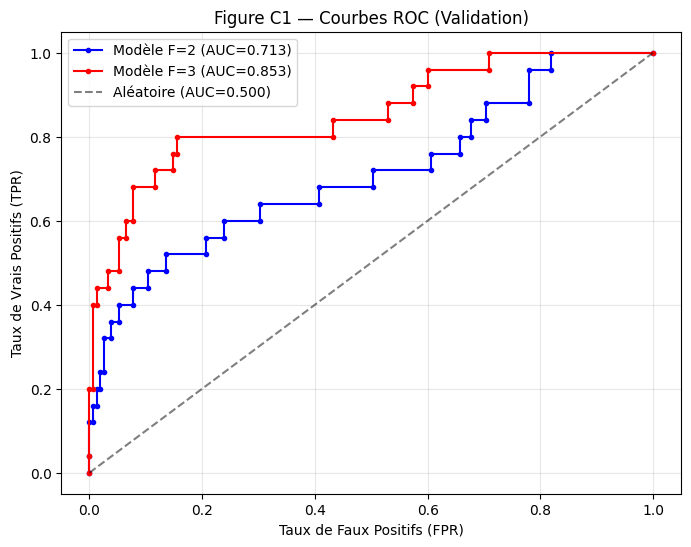

In [7]:
# Calcul des probabilités pour les courbes ROC
pva_F2 = model_F2.predict_proba(x_valid[cols_F2])[:, 1]
pva_F3 = model_F3.predict_proba(x_valid[cols_F3])[:, 1]

fpr2, tpr2, _ = roc_curve(yva, pva_F2)
fpr3, tpr3, _ = roc_curve(yva, pva_F3)
auc2 = roc_auc_score(yva, pva_F2)
auc3 = roc_auc_score(yva, pva_F3)

plt.figure(figsize=(8, 6))
plt.plot(fpr2, tpr2, 'b.-', label=f"Modèle F=2 (AUC={auc2:.3f})")
plt.plot(fpr3, tpr3, 'r.-', label=f"Modèle F=3 (AUC={auc3:.3f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label="Aléatoire (AUC=0.500)")
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Figure C1 — Courbes ROC (Validation)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("figure_C1.png")
plt.show()

## Bloc D — Choix du seuil de décision (Modèle F=3)

In [8]:
# Calcul des métriques sur validation pour différents seuils
pva_F3 = model_F3.predict_proba(x_valid[cols_F3])[:, 1]
pte_F3 = model_F3.predict_proba(x_test[cols_F3])[:, 1]

thresholds = np.linspace(0, 1, 1001)
metrics_va = []
for t in thresholds:
    yp = (pva_F3 >= t).astype(int)
    metrics_va.append((t, calc_TPR(yva, yp), calc_PPV(yva, yp)))
df_metrics = pd.DataFrame(metrics_va, columns=['t', 'tpr', 'ppv'])

# Stratégie 1 : seuil par défaut 0.5
thr1 = 0.5

# Stratégie 2 : maximiser TPR sous contrainte PPV >= 0.98 (Priorité : Biopsies de haute qualité)
s2 = df_metrics[df_metrics['ppv'] >= 0.98]
thr2 = s2.loc[s2['tpr'].idxmax(), 't'] if not s2.empty else df_metrics.loc[df_metrics['ppv'].idxmax(), 't']

# Stratégie 3 : maximiser PPV sous contrainte TPR >= 0.98 (Priorité : Éviter les faux négatifs / mort)
s3 = df_metrics[df_metrics['tpr'] >= 0.98]
thr3 = s3.loc[s3['ppv'].idxmax(), 't'] if not s3.empty else df_metrics.loc[df_metrics['tpr'].idxmax(), 't']

print(f"Seuils choisis : Strat 1=0.5, Strat 2={thr2:.3f}, Strat 3={thr3:.3f}")

Seuils choisis : Strat 1=0.5, Strat 2=0.606, Strat 3=0.028


## Figure D1 — Performance sur le jeu de test

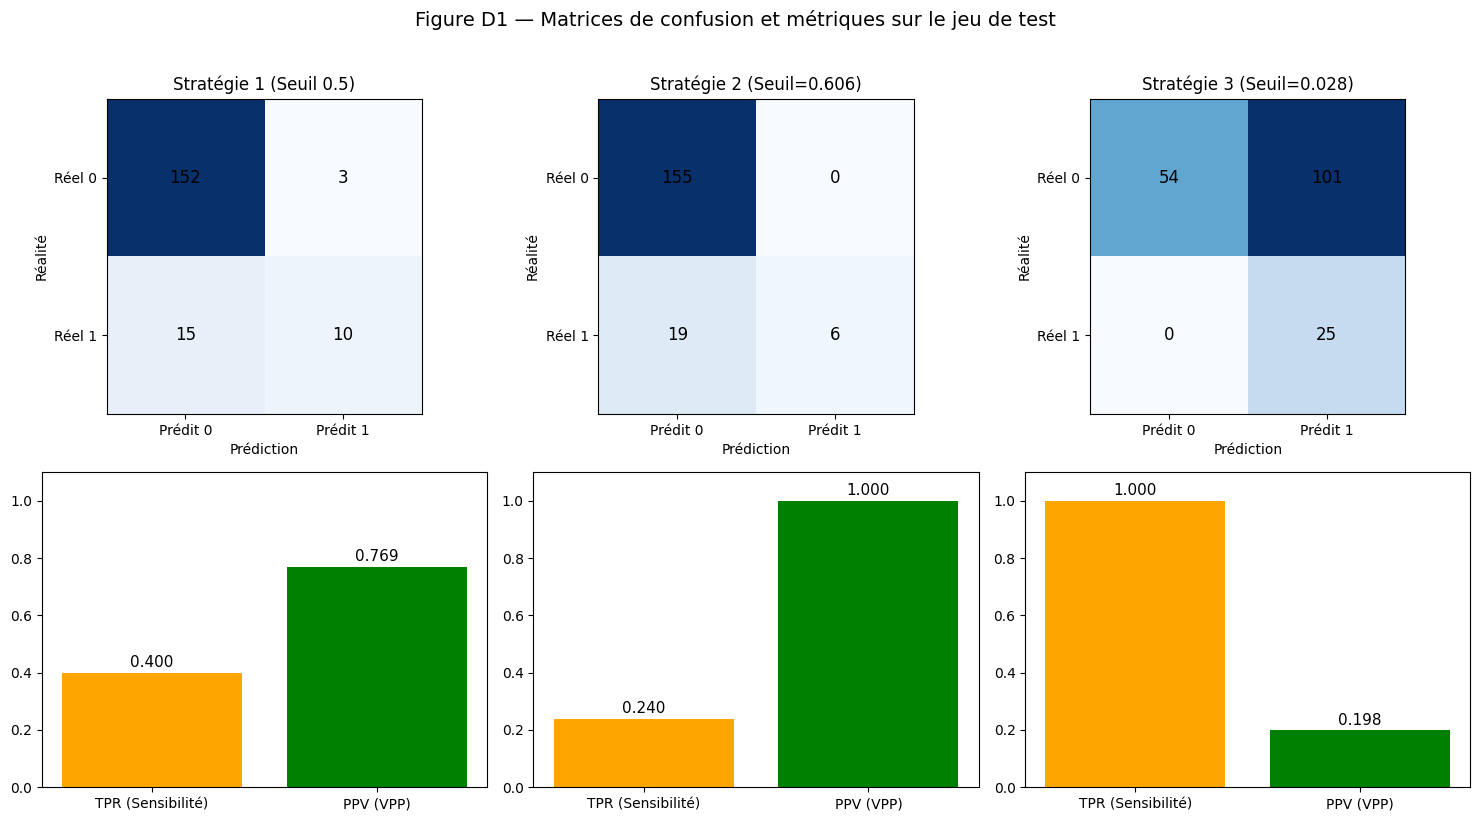

In [9]:
def evaluate_test(thr, name):
    yp = (pte_F3 >= thr).astype(int)
    TP, TN, FP, FN = calc_TP_TN_FP_FN(yte, yp)
    return {"name": name, "cm": np.array([[TN, FP], [FN, TP]]), "tpr": calc_TPR(yte, yp), "ppv": calc_PPV(yte, yp)}

results = [
    evaluate_test(thr1, "Stratégie 1 (Seuil 0.5)"),
    evaluate_test(thr2, f"Stratégie 2 (Seuil={thr2:.3f})"),
    evaluate_test(thr3, f"Stratégie 3 (Seuil={thr3:.3f})")
]

plt.figure(figsize=(15, 8))
for i, res in enumerate(results):
    # Affichage de la matrice de confusion
    ax_cm = plt.subplot(2, 3, i+1)
    ax_cm.imshow(res["cm"], cmap='Blues')
    ax_cm.set_title(res["name"])
    for (r, c), val in np.ndenumerate(res["cm"]):
        ax_cm.text(c, r, str(val), ha='center', va='center', fontsize=12)
    ax_cm.set_xticks([0, 1]); ax_cm.set_xticklabels(["Prédit 0", "Prédit 1"])
    ax_cm.set_yticks([0, 1]); ax_cm.set_yticklabels(["Réel 0", "Réel 1"])
    ax_cm.set_xlabel("Prédiction")
    ax_cm.set_ylabel("Réalité")
    
    # Affichage des métriques TPR et PPV
    ax_m = plt.subplot(2, 3, i+4)
    ax_m.bar(["TPR (Sensibilité)", "PPV (VPP)"], [res["tpr"], res["ppv"]], color=['orange', 'green'])
    ax_m.set_ylim(0, 1.1)
    for j, val in enumerate([res["tpr"], res["ppv"]]):
        ax_m.text(j, val+0.02, f"{val:.3f}", ha='center', fontsize=11)

plt.suptitle("Figure D1 — Matrices de confusion et métriques sur le jeu de test", y=1.02, fontsize=14)
plt.tight_layout()
plt.savefig("figure_D1.png")
plt.show()

## Bloc E — Perte logistique et stabilité numérique (NumPy)

In [10]:
def calc_mean_binary_cross_entropy_from_probas(y_true, p_pred, eps=1e-14):
    '''Calcule la BCE moyenne à partir des probabilités avec écrêtage (clipping).'''
    p_pred = np.clip(p_pred, eps, 1-eps)
    bce = - y_true * np.log2(p_pred) - (1-y_true) * np.log2(1-p_pred)
    return np.mean(bce)

def my_logsumexp(a):
    '''Calcule log(sum(exp(a))) de manière stable.'''
    a_max = np.max(a)
    return a_max + np.log(np.sum(np.exp(a - a_max)))

def calc_mean_binary_cross_entropy_from_scores(y_true, s_pred):
    '''Calcule la BCE moyenne à partir des scores réels en utilisant logsumexp.'''
    vals = []
    for y, s in zip(y_true, s_pred):
        z = (1 - 2*y) * s
        # log2(1 + exp(z)) = logsumexp([0, z]) / log(2)
        lse = my_logsumexp(np.array([0, z]))
        vals.append(lse / np.log(2))
    return np.mean(vals)

# Vérification Stabilité
yt_e = np.array([1, 0, 1, 0])
s_e = np.array([2.0, -2.0, 1.0, -1.0])
sig_e = 1.0 / (1.0 + np.exp(-s_e))
bce_p = calc_mean_binary_cross_entropy_from_probas(yt_e, sig_e)
bce_s = calc_mean_binary_cross_entropy_from_scores(yt_e, s_e)
print(f"BCE probas : {bce_p:.6f}")
print(f"BCE scores : {bce_s:.6f}")
assert abs(bce_p - bce_s) < 1e-8

# Test de stabilité avec score large
s_large = np.array([1000.0, -1000.0])
y_large = np.array([0, 1])
bce_p_large = calc_mean_binary_cross_entropy_from_probas(y_large, 1.0/(1.0+np.exp(-s_large)))
bce_s_large = calc_mean_binary_cross_entropy_from_scores(y_large, s_large)
print(f"Large score stability - BCE probas (avec eps) : {bce_p_large:.4f}, BCE scores : {bce_s_large:.4f}")

BCE probas : 0.317530
BCE scores : 0.317530
Large score stability - BCE probas (avec eps) : 46.5076, BCE scores : 1442.6950


/tmp/ipykernel_3669/172161443.py:35: RuntimeWarning: overflow encountered in exp
  bce_p_large = calc_mean_binary_cross_entropy_from_probas(y_large, 1.0/(1.0+np.exp(-s_large)))


In [11]:
# Extraction des résultats pour le rapport
with open("report_values.txt", "w") as f:
    f.write("--- TABLE A1 ---\n")
    f.write(summary.to_string() + "\n\n")
    f.write(f"Baseline Accuracy: {acc0:.4f}\n")
    f.write(f"Best C F2: {best_C_F2}, Best C F3: {best_C_F3}\n")
    f.write(f"AUC F2: {auc2:.4f}, AUC F3: {auc3:.4f}\n")
    f.write(f"Thresholds: Strat 1=0.5, Strat 2={thr2:.3f}, Strat 3={thr3:.3f}\n")
    for res in results:
        f.write(f"{res['name']} -> CM:\n{res['cm']}\nTPR: {res['tpr']:.4f}, PPV: {res['ppv']:.4f}\n")
        tn = res['cm'][0,0]
        f.write(f"Biopsies inutiles évitées : {tn} ({tn/summary.loc['Test', 'total_obs']*100:.1f}% du total)\n")
